In [53]:
import pandas as pd
df = pd.read_excel('40_pacientes_controle.xlsx')
print((df.dtypes))
print(df.isnull().sum())


Ident        int64
Sexo        object
Idade        int64
Peso       float64
NYHA         int64
CARGA        int64
FC           int64
VO2        float64
RER        float64
VE/VO2     float64
dtype: object
Ident      0
Sexo       0
Idade      0
Peso       0
NYHA       0
CARGA      0
FC         0
VO2        0
RER        0
VE/VO2     0
dtype: int64


In [38]:
from docx import Document
from docx.shared import Inches

desc = df.describe().round(2)
doc = Document()
doc.add_heading('Estatísticas Descritivas', 0)
table = doc.add_table(rows=1, cols=len(desc.columns) + 1)
table.style = 'Table Grid'
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Estatística'
for i, column in enumerate(desc.columns):
    hdr_cells[i+1].text = column

for stat in desc.index:
    row_cells = table.add_row().cells
    row_cells[0].text = stat
    for i, value in enumerate(desc.loc[stat]):
        row_cells[i+1].text = str(value)

doc.save('estatisticas_descritivas_controle.docx')

print("Documento Word com estatísticas descritivas foi criado.")

Documento Word com estatísticas descritivas foi criado.


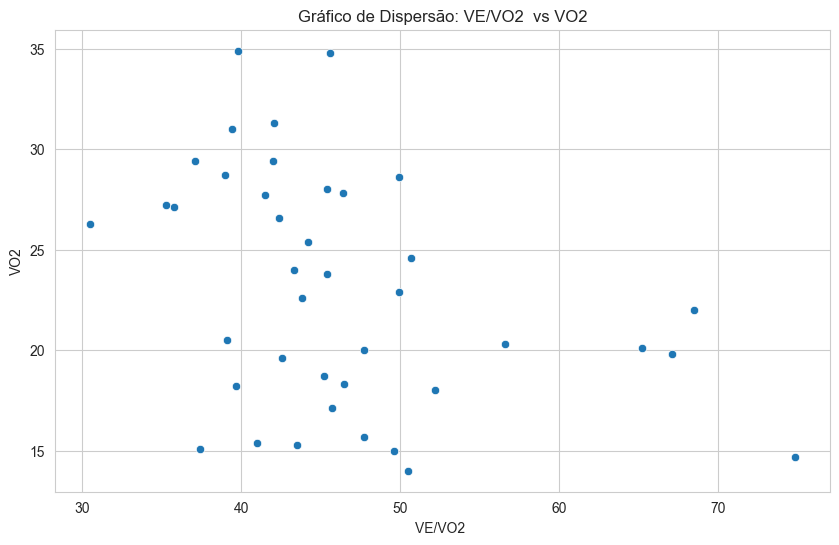

Gráfico de dispersão de VE/VO2  vs VO2 criado com sucesso.


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

def criar_grafico_dispersao(df, x, y):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x, y=y)
    plt.title(f'Gráfico de Dispersão: {x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

    print(f"Gráfico de dispersão de {x} vs {y} criado com sucesso.")

x = 'VE/VO2 '
y = 'VO2'
criar_grafico_dispersao(df, x, y)


In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH
from sklearn.utils import resample

X = df[['Idade', 'Peso', 'NYHA', 'CARGA', 'FC', 'RER', 'VE/VO2 ']]
y = df['VO2']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

modelo = Ridge(alpha=1.0)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

def bootstrap_se(X, y, model, n_iterations=1000):
    se = []
    for _ in range(n_iterations):
        X_boot, y_boot = resample(X, y)
        model.fit(X_boot, y_boot)
        se.append(model.coef_)
    return np.std(se, axis=0)

se = bootstrap_se(X_train, y_train, Ridge(alpha=1.0))

doc = Document()
doc.add_heading('Resultados da Regressão', 0)

doc.add_heading('Equação da Regressão', level=1)
p = doc.add_paragraph()
p.alignment = WD_ALIGN_PARAGRAPH.CENTER
r = p.add_run()
r.add_text('VO2 = ')
r.font.math = True

equation = f"{modelo.intercept_:.4f}"
for var, coef in zip(X.columns, modelo.coef_):
    if coef >= 0:
        equation += f" + {abs(coef):.4f} * {var}"
    else:
        equation += f" - {abs(coef):.4f} * {var}"

r.add_text(equation)

doc.add_heading('Coeficientes das Variáveis', level=1)
table = doc.add_table(rows=1, cols=3)
table.style = 'Table Grid'
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Variável'
hdr_cells[1].text = 'Coeficiente'
hdr_cells[2].text = 'Erro Padrão'

for var, coef, erro in zip(X.columns, modelo.coef_, se):
    row_cells = table.add_row().cells
    row_cells[0].text = var
    row_cells[1].text = f"{coef:.4f}"
    row_cells[2].text = f"{erro:.4f}"

doc.add_heading('Métricas de Desempenho', level=1)
doc.add_paragraph(f"Acurácia do modelo (R² Score): {r2:.4f}")
doc.add_paragraph(f"Erro Quadrático Médio: {mse:.4f}")

doc.save('resultados_regressao_controle2.docx')

print("Documento Word com resultados da regressão foi criado.")

Documento Word com resultados da regressão foi criado.


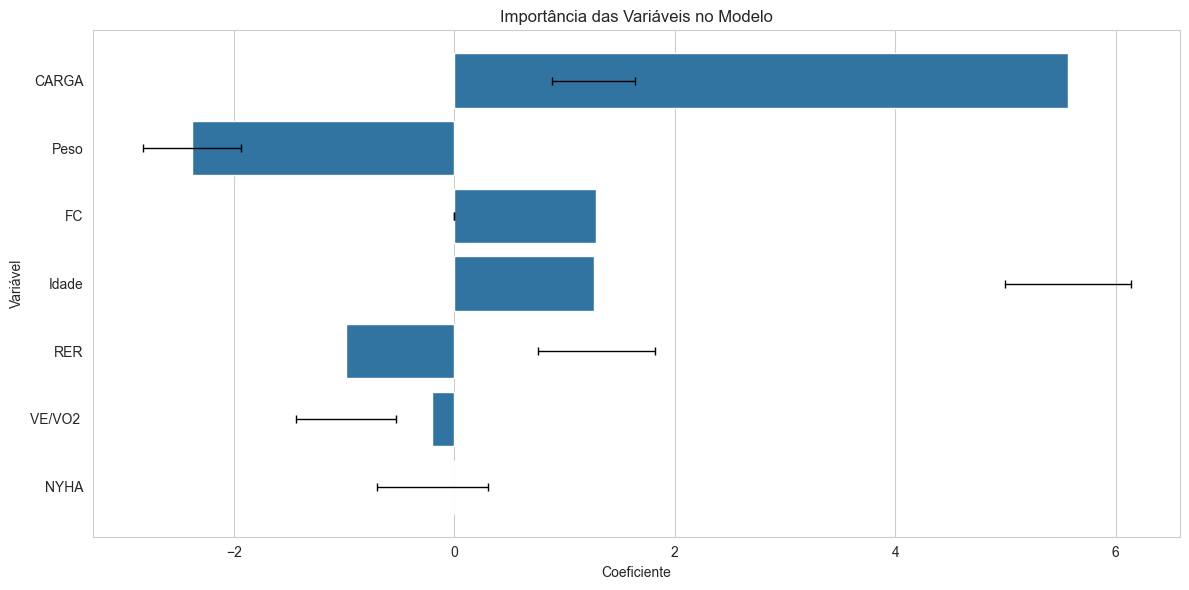

Gráfico de importância das variáveis foi plotado no console.


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
coef_importances = pd.DataFrame({'variavel': X.columns, 'coeficiente': modelo.coef_, 'erro_padrao': se})
coef_importances = coef_importances.sort_values('coeficiente', key=abs, ascending=False)

sns.barplot(x='coeficiente', y='variavel', data=coef_importances)

for i, row in coef_importances.iterrows():
    plt.errorbar(row['coeficiente'], i, xerr=row['erro_padrao'], capsize=3, color='black', linewidth=1)

plt.title('Importância das Variáveis no Modelo')
plt.xlabel('Coeficiente')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

print("Gráfico de importância das variáveis foi plotado no console.")